# Regression Models with Keras

## Objectives for this Notebook    
* How to use the Keras library to build a regression model
* Download and clean the data set
* Build a neural network
* Train and test the network     



## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>
    
1. <a href="#item31">Download and Clean the Data Set</a>  
2. <a href="#item32">Import Keras Packages</a>
3. <a href="#item33">Build a Neural Network</a>
4. <a href="#item34">Train and Test the Network</a>  

</font>
</div>


<a id="item31"></a>


## Download and Clean the  Data Set


Let's start by importing the <em>pandas</em> and the Numpy libraries.


In [2]:
# All Libraries required for this lab are listed below. The libraries pre-installed on Skills Network Labs are commented. 
!pip install numpy==1.26.0
!pip install pandas==2.2.2
!pip install tensorflow_cpu==2.18.0
!pip install scikit-learn
!pip install matplotlib

In [3]:
import pandas as pd
import numpy as np
import keras
import os
import time
# Disable oneDNN optimizations if you don't want the floating-point precision warning
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import warnings
warnings.simplefilter('ignore', FutureWarning)

2025-12-23 18:05:45.827426: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-23 18:05:45.854303: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-23 18:05:46.682360: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


<strong>The dataset is about the compressive strength of different samples of concrete based on the volumes of the different ingredients that were used to make them. Ingredients include:</strong>

* Cement
* Blast furnace slag
* Fly ash
* Water
* Superplasticizer
* Coarse aggregate
* Fine aggregate


Let's download the data and read it into a <em>pandas</em> dataframe.


In [4]:
filepath='https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0101EN/labs/data/concrete_data.csv'
concrete_data = pd.read_csv(filepath)

concrete_data.head()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


Let's check the dataset for any missing values.

In [5]:
concrete_data.info


<bound method DataFrame.info of       Cement  Blast Furnace Slag  Fly Ash  Water  Superplasticizer  \
0      540.0                 0.0      0.0  162.0               2.5   
1      540.0                 0.0      0.0  162.0               2.5   
2      332.5               142.5      0.0  228.0               0.0   
3      332.5               142.5      0.0  228.0               0.0   
4      198.6               132.4      0.0  192.0               0.0   
...      ...                 ...      ...    ...               ...   
1025   276.4               116.0     90.3  179.6               8.9   
1026   322.2                 0.0    115.6  196.0              10.4   
1027   148.5               139.4    108.6  192.7               6.1   
1028   159.1               186.7      0.0  175.6              11.3   
1029   260.9               100.5     78.3  200.6               8.6   

      Coarse Aggregate  Fine Aggregate  Age  Strength  
0               1040.0           676.0   28     79.99  
1              

**Comment**: The data looks very clean and is ready to be used to build our model.


#### Let's check how many data points we have


In [6]:
concrete_data.shape

(1030, 9)

So, there are approximately 1000 samples to train our model on. Because of the few samples, we have to be careful not to overfit the training data.


Let's check the dataset for any missing values.


#### Split data into predictors and target


The target variable in this problem is the concrete sample strength. Therefore, our predictors will be all the other columns.


In [7]:
concrete_data_columns = concrete_data.columns

In [8]:
predictors = concrete_data[concrete_data_columns[concrete_data_columns != 'Strength']] # all columns except Strength
target = concrete_data['Strength'] # Strength column

<a id="item2"></a>


Let's do a quick sanity check of the predictors and the target dataframes.


In [9]:
predictors.head()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360


**Comment**: Predictors contains only the first 8 columns


In [10]:
target.head()

0    79.99
1    61.89
2    40.27
3    41.05
4    44.30
Name: Strength, dtype: float64

Finally, the last step is to normalize the data by substracting the mean and dividing by the standard deviation.


In [11]:
predictors_norm = (predictors - predictors.mean()) / predictors.std()
predictors_norm.head()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age
0,2.476712,-0.856472,-0.846733,-0.916319,-0.620147,0.862735,-1.217079,-0.279597
1,2.476712,-0.856472,-0.846733,-0.916319,-0.620147,1.055651,-1.217079,-0.279597
2,0.491187,0.795140,-0.846733,2.174405,-1.038638,-0.526262,-2.239829,3.551340
3,0.491187,0.795140,-0.846733,2.174405,-1.038638,-0.526262,-2.239829,5.055221
4,-0.790075,0.678079,-0.846733,0.488555,-1.038638,0.070492,0.647569,4.976069


<a id='item32'></a>


##  Import Keras Packages

##### Let's import the rest of the packages from the Keras library that we will need to build our regression model.


In [12]:
from keras.models import Sequential # Model API
from keras.layers import Dense # Fully connected layers
from keras.layers import Input # Input Layer

<a id='item33'></a>


## Build a Neural Network


Let's define a function that defines our regression model for us so that we can conveniently call it to create our model.


In [13]:
# define regression model
n_cols = predictors.shape[1] # number of predictors
print("Input shape: {}".format(n_cols))
def regression_model():
    # Specify model
    model = Sequential([
    # Define 8 Nodes in the input Layer + 50 Nodes in the first Hidden layers
    # N. parameters between input & first Hidden = 8 x 50 + 50 bias = 450
        Input(shape=(n_cols,)),  # Define input shape explicitly
        Dense(50, activation='relu')
    ])
    # N. parameters between first Hidden & second Hidden = 50 x 50+ 50 bias = 2550
    model.add(Dense(50, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.summary()
    # compile model
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

Input shape: 8


**Comment**: The above function create a model that has three hidden layers, each of 50 hidden units.


<a id="item4"></a>


## Train and Test the Network


Let's call the function now to create our model.


In [14]:
# build the model
model = regression_model()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 50)             │           450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,601 (21.88 KB)

 Trainable params: 5,601 (21.88 KB)

 Non-trainable params: 0 (0.00 B)

Next, we will train and test the model at the same time using the *fit* method. We will leave out 30% of the data for validation and we will train the model for 100 epochs.


In [15]:
# fit the model
history = model.fit(predictors_norm, target, validation_split=0.3, epochs=700, verbose=2)

Epoch 1/700
23/23 - 1s - 24ms/step - loss: 1605.9946 - val_loss: 1063.3883
Epoch 2/700
23/23 - 0s - 3ms/step - loss: 1288.4556 - val_loss: 684.6524
Epoch 3/700
23/23 - 0s - 3ms/step - loss: 602.6681 - val_loss: 235.1365
Epoch 4/700
23/23 - 0s - 3ms/step - loss: 257.4344 - val_loss: 194.3938
Epoch 5/700
23/23 - 0s - 2ms/step - loss: 221.8907 - val_loss: 177.1251
Epoch 6/700
23/23 - 0s - 3ms/step - loss: 207.6687 - val_loss: 174.5142
Epoch 7/700
23/23 - 0s - 2ms/step - loss: 197.4460 - val_loss: 171.9843
Epoch 8/700
23/23 - 0s - 2ms/step - loss: 189.4585 - val_loss: 166.1908
Epoch 9/700
23/23 - 0s - 2ms/step - loss: 181.5695 - val_loss: 166.5034
Epoch 10/700
23/23 - 0s - 2ms/step - loss: 175.4072 - val_loss: 159.5004
Epoch 11/700
23/23 - 0s - 2ms/step - loss: 170.0431 - val_loss: 158.8173
Epoch 12/700
23/23 - 0s - 2ms/step - loss: 163.9784 - val_loss: 153.2583
Epoch 13/700
23/23 - 0s - 2ms/step - loss: 158.0313 - val_loss: 157.7075
Epoch 14/700
23/23 - 0s - 2ms/step - loss: 151.4706 - va

##  Plot the Loss function

We plot the folllowing quantities over the epochs history
- Training Loss is the error measured on the training dataset during training. Reflects how well the model fits the data it has seen.
- Validation Loss is the error measured on a separate validation set not used for training. Reflects generalization to unseen data.

dict_keys(['loss', 'val_loss'])


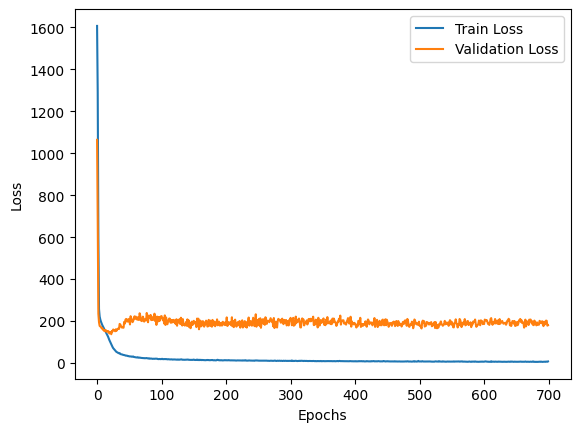

In [16]:
import matplotlib.pyplot as plt
# Plot Loss
print(history.history.keys())
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Comment**: The data shuld reveals one of the following options
- Good sign: both losses decrease and stabilize.
- Overfitting: training loss ↓, validation loss ↑
- Underfitting: both losses remain high

In [17]:
# predictions will contain model outputs for each sample in x_train
predictions = model.predict(predictors_norm)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step


**Comment**:The highest value in each row is the predicted class.

[67.92106]


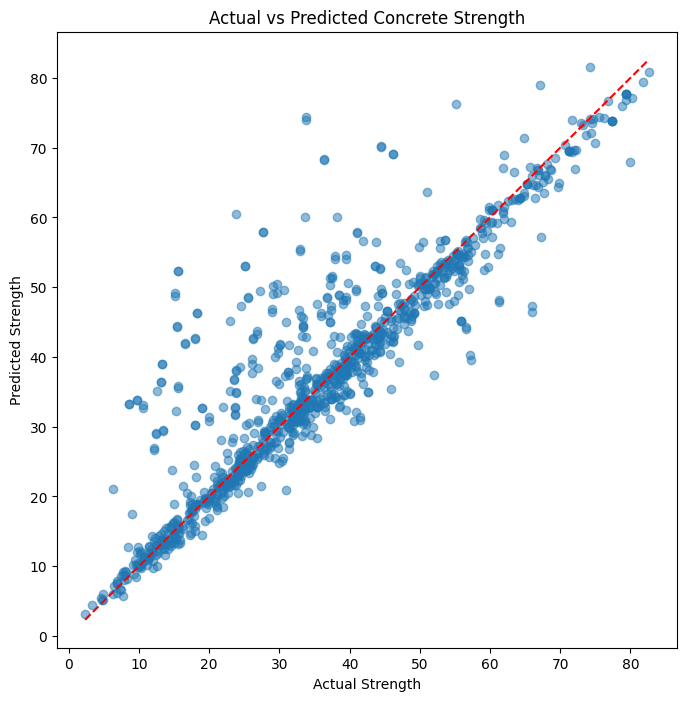

In [18]:
# Make predictions
print(predictions[0])
plt.figure(figsize=(8,8))
plt.scatter(target, predictions, alpha=0.5)
plt.xlabel("Actual Strength")
plt.ylabel("Predicted Strength")
plt.title("Actual vs Predicted Concrete Strength")
plt.plot([target.min(), target.max()],
        [target.min(), target.max()], 'r--')
plt.show()